In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
import FinanceDataReader as fdr
from datetime import datetime
from alpha_code_1 import get_alpha

In [3]:
start_date = '2001-01-01'
end_date = '2020-12-31'

df = fdr.DataReader('KS11', start_date, end_date)
df = df.reset_index()

df = df.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df = get_alpha(df)

# 1. 결측값 채우기 (forward fill → backward fill → 0 대체)
def fill_missing(df):
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    df = df.fillna(0)
    return df

# 2. 정규화 (표준화: 평균 0, 표준편차 1)
def normalize(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    return pd.DataFrame(scaled, index=df.index, columns=df.columns)

# 3. 이산형 / 연속형 분리
def separate_discrete_continuous(df, threshold=10):
    discrete_features = []
    continuous_features = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values <= threshold:
            discrete_features.append(col)
        else:
            continuous_features.append(col)
    return discrete_features, continuous_features

# 4. 중복 feature 제거 (feature 값이 거의 비슷한 경우 제거)
def remove_duplicate_features(df, duplicate_threshold=0.2):
    to_remove = []
    for col in df.columns:
        freq = df[col].value_counts(normalize=True).max()
        if freq > duplicate_threshold:
            to_remove.append(col)
    df_cleaned = df.drop(columns=to_remove)
    return df_cleaned, to_remove


# 5. 전체 파이프라인 함수
def clean_features(df):
    print("원본 feature 수:", df.shape[1])

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 정규화
    df = normalize(df)
    print("정규화 완료")

    # 이산형/연속형 분리
    discrete_features, continuous_features = separate_discrete_continuous(df)
    print(f"이산형 feature 수: {len(discrete_features)}, 연속형 feature 수: {len(continuous_features)}")

    # 중복 feature 제거
    df_cleaned, removed_features = remove_duplicate_features(df)
    print(f"중복 feature 제거 완료 (제거한 feature 수: {len(removed_features)})")

    print("최종 feature 수:", df_cleaned.shape[1])
    return df_cleaned, discrete_features, continuous_features, removed_features

# S_DQ_ 로 시작하는 원본 칼럼들은 제외하고 알파만 선택
alpha_cols = [col for col in df.columns if col.startswith('alpha')]
df_alphas_only = df[alpha_cols]

# 파이프라인 적용
df_cleaned, discrete_features, continuous_features, removed_features = clean_features(df_alphas_only)

# 1. 상관 높은 feature 제거 함수
def remove_highly_correlated_features(df, correlation_threshold=0.99):
    corr_matrix = df.corr().abs()  # 절댓값 상관계수 계산
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    
    df_cleaned = df.drop(columns=to_drop)
    
    return df_cleaned, to_drop

# 1. 상관 높은 feature 제거
df_uncorrelated, dropped_corr_features = remove_highly_correlated_features(df_cleaned, correlation_threshold=0.99)

print(f"상관 관계로 제거한 feature 수: {len(dropped_corr_features)}")

c:\Users\minju\OneDrive\바탕 화면\다트비\캐금스\alpha_code_1.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner[self.returns < 0] = stddev(self.returns, 20)


원본 feature 수: 82
결측값 채우기 완료
정규화 완료
이산형 feature 수: 16, 연속형 feature 수: 66
중복 feature 제거 완료 (제거한 feature 수: 23)
최종 feature 수: 59
상관 관계로 제거한 feature 수: 0


c:\Users\minju\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1066: RuntimeWarning: overflow encountered in square
  temp **= 2
c:\Users\minju\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\minju\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\minju\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:86: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


In [12]:
# 2. k개 feature 최종 선택 (분산 큰 순서대로)
def select_top_variance_features(df, top_k):
    variances = df.var().sort_values(ascending=False)
    selected_features = variances.head(top_k).index.tolist()
    df_selected = df[selected_features]
    return df_selected, selected_features

#k=58
df_selected, selected_features = select_top_variance_features(df_uncorrelated, top_k=58)

df_selected['target'] = df['UpDown'].shift(-1)
df_selected['target'] = df_selected['target'].replace(3, 2)
df_selected['target'] = df_selected['target'].replace(1, 0)
df_selected['target'] = df_selected['target'].replace(2, 1)

df_selected = df_selected.dropna()
X_full = df_selected.drop(columns=['target'])
y_full = df_selected['target']

In [10]:
print(range(58))

range(0, 58)


In [44]:
from sklearn.feature_selection import RFE

for n in range(10, 59):

    model = LogisticRegression(
        penalty='l2',
        C=0.01,
        solver='lbfgs',
        class_weight='balanced',
        max_iter=500,
        random_state=42
    )
    
    rfe = RFE(estimator=model, n_features_to_select=n)
    rfe.fit(X_full, y_full)

    selected_features = X_full.columns[rfe.support_]

    X = df_selected[selected_features]
    y = df_selected['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"For n = {n}")
    print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")
    print(f"Test Accuracy: {model.score(X_test, y_test):.4f}\n")

For n = 10
Train Accuracy: 0.5340
Test Accuracy: 0.5076

For n = 11
Train Accuracy: 0.5368
Test Accuracy: 0.5268

For n = 12
Train Accuracy: 0.5398
Test Accuracy: 0.5369

For n = 13
Train Accuracy: 0.5360
Test Accuracy: 0.5420

For n = 14
Train Accuracy: 0.5335
Test Accuracy: 0.5329

For n = 15
Train Accuracy: 0.5378
Test Accuracy: 0.5147

For n = 16
Train Accuracy: 0.5378
Test Accuracy: 0.5167

For n = 17
Train Accuracy: 0.5414
Test Accuracy: 0.5056

For n = 18
Train Accuracy: 0.5419
Test Accuracy: 0.5056

For n = 19
Train Accuracy: 0.5467
Test Accuracy: 0.5126

For n = 20
Train Accuracy: 0.5449
Test Accuracy: 0.5147

For n = 21
Train Accuracy: 0.5459
Test Accuracy: 0.5147

For n = 22
Train Accuracy: 0.5419
Test Accuracy: 0.5177

For n = 23
Train Accuracy: 0.5429
Test Accuracy: 0.5157

For n = 24
Train Accuracy: 0.5535
Test Accuracy: 0.5106

For n = 25
Train Accuracy: 0.5530
Test Accuracy: 0.5116

For n = 26
Train Accuracy: 0.5543
Test Accuracy: 0.5086

For n = 27
Train Accuracy: 0.55

In [45]:
model = LogisticRegression(
    penalty='l2',
    C=0.01,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=500,
    random_state=42
)

#RFE를 통해 feature 수 감소
rfe = RFE(estimator=model, n_features_to_select=13)

# 3. RFE 실행 (fit)
rfe.fit(X_full, y_full)

# 4. 선택된 feature 확인
selected_features = X_full.columns[rfe.support_]

X = df_selected[selected_features]
y = df_selected['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model.fit(X_train,y_train)

#Predicting train and test set result
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.4f}\n")

Train Accuracy: 0.5360
Test Accuracy: 0.5420



In [46]:
print("🔍 Classification Report:\n", classification_report(y_test, y_test_pred))

🔍 Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.43      0.51       552
         1.0       0.49      0.68      0.57       437

    accuracy                           0.54       989
   macro avg       0.56      0.56      0.54       989
weighted avg       0.57      0.54      0.54       989



In [47]:
# 모델의 coefficients
coefficients = model.coef_[0]  # (이진 분류면 1차원 배열)

# feature names
feature_names = X.columns

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# 영향력 큰 순서대로 정렬
importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

print(importance_df)


     feature  coefficient  abs_coefficient
8   alpha015     0.094748         0.094748
7   alpha035     0.081215         0.081215
0   alpha033     0.074531         0.074531
5   alpha016    -0.068291         0.068291
3   alpha085     0.057787         0.057787
11  alpha034     0.053319         0.053319
4   alpha032     0.053197         0.053197
9   alpha009    -0.051920         0.051920
10  alpha045     0.045135         0.045135
2   alpha050     0.042205         0.042205
6   alpha022     0.035798         0.035798
1   alpha008    -0.034942         0.034942
12  alpha071    -0.030223         0.030223


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score

param_grid = [
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'C': [0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced', None],
        'max_iter': [500, 1000]
    },
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced', None],
        'max_iter': [500, 1000]
    }
]
# 사용할 평가 지표들
scoring_metrics = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': 'roc_auc'  # 미리 정의된 스코어
}

# 결과 저장용
results_summary = {}

# 반복 실행: 각 scoring에 대해 GridSearchCV 수행
for metric_name, scorer in scoring_metrics.items():
    print(f"\n🔍 GridSearchCV (scoring = {metric_name})")
    
    grid = GridSearchCV(
        LogisticRegression(random_state=42),
        param_grid,
        cv=5,
        scoring=scorer,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    
    print("최적 하이퍼파라미터:", grid.best_params_)
    print(f"최고 {metric_name} 점수: {grid.best_score_:.4f}")
    
    # 결과 저장
    results_summary[metric_name] = {
        'best_params': grid.best_params_,
        'best_score': grid.best_score_
    }


🔍 GridSearchCV (scoring = f1)
최적 하이퍼파라미터: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
최고 f1 점수: 0.4911

🔍 GridSearchCV (scoring = precision)
최적 하이퍼파라미터: {'C': 0.01, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
최고 precision 점수: 0.5010

🔍 GridSearchCV (scoring = recall)
최적 하이퍼파라미터: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
최고 recall 점수: 0.7060

🔍 GridSearchCV (scoring = roc_auc)
최적 하이퍼파라미터: {'C': 1, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
최고 roc_auc 점수: 0.5258


Threshold=0.450 | Precision(1)=0.455 | Recall(1)=0.945 | Precision(0)=0.704 | Recall(0)=0.103 | Accuracy=0.475
Threshold=0.451 | Precision(1)=0.454 | Recall(1)=0.943 | Precision(0)=0.695 | Recall(0)=0.103 | Accuracy=0.474
Threshold=0.452 | Precision(1)=0.457 | Recall(1)=0.938 | Precision(0)=0.703 | Recall(0)=0.116 | Accuracy=0.479
Threshold=0.453 | Precision(1)=0.456 | Recall(1)=0.936 | Precision(0)=0.699 | Recall(0)=0.118 | Accuracy=0.479
Threshold=0.454 | Precision(1)=0.456 | Recall(1)=0.929 | Precision(0)=0.684 | Recall(0)=0.121 | Accuracy=0.478
Threshold=0.455 | Precision(1)=0.456 | Recall(1)=0.927 | Precision(0)=0.680 | Recall(0)=0.123 | Accuracy=0.478
Threshold=0.456 | Precision(1)=0.457 | Recall(1)=0.927 | Precision(0)=0.689 | Recall(0)=0.129 | Accuracy=0.481
Threshold=0.457 | Precision(1)=0.458 | Recall(1)=0.927 | Precision(0)=0.695 | Recall(0)=0.132 | Accuracy=0.483
Threshold=0.458 | Precision(1)=0.458 | Recall(1)=0.922 | Precision(0)=0.691 | Recall(0)=0.138 | Accuracy=0.484
T

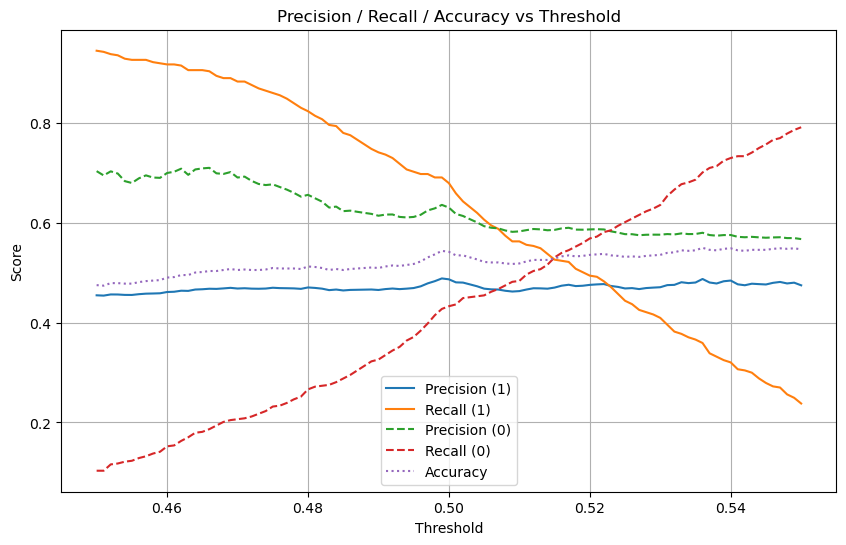

In [33]:
# 1. 확률 예측
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. threshold 리스트
thresholds = np.arange(0.45, 0.55, 0.001)

# 3. 저장할 리스트
precision_1_list = []
recall_1_list = []
precision_0_list = []
recall_0_list = []
accuracy_list = []

# 4. 각 threshold에 대해 계산
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    precision_1 = precision_score(y_test, y_pred_custom, pos_label=1)
    recall_1 = recall_score(y_test, y_pred_custom, pos_label=1)
    precision_0 = precision_score(y_test, y_pred_custom, pos_label=0)
    recall_0 = recall_score(y_test, y_pred_custom, pos_label=0)
    accuracy = accuracy_score(y_test, y_pred_custom)

    precision_1_list.append(precision_1)
    recall_1_list.append(recall_1)
    precision_0_list.append(precision_0)
    recall_0_list.append(recall_0)
    accuracy_list.append(accuracy)

# 5. 결과 출력
for t, p1, r1, p0, r0, acc in zip(thresholds, precision_1_list, recall_1_list, precision_0_list, recall_0_list, accuracy_list):
    print(f"Threshold={t:.3f} | Precision(1)={p1:.3f} | Recall(1)={r1:.3f} | Precision(0)={p0:.3f} | Recall(0)={r0:.3f} | Accuracy={acc:.3f}")

# 6. 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_1_list, label='Precision (1)', linestyle='-')
plt.plot(thresholds, recall_1_list, label='Recall (1)', linestyle='-')
plt.plot(thresholds, precision_0_list, label='Precision (0)', linestyle='--')
plt.plot(thresholds, recall_0_list, label='Recall (0)', linestyle='--')
plt.plot(thresholds, accuracy_list, label='Accuracy', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

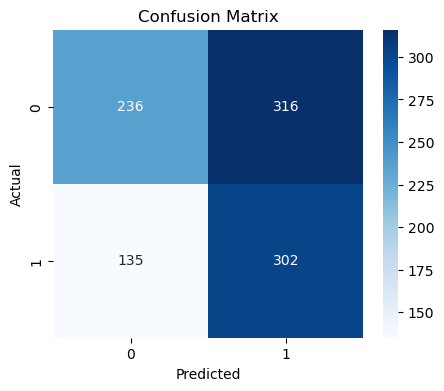

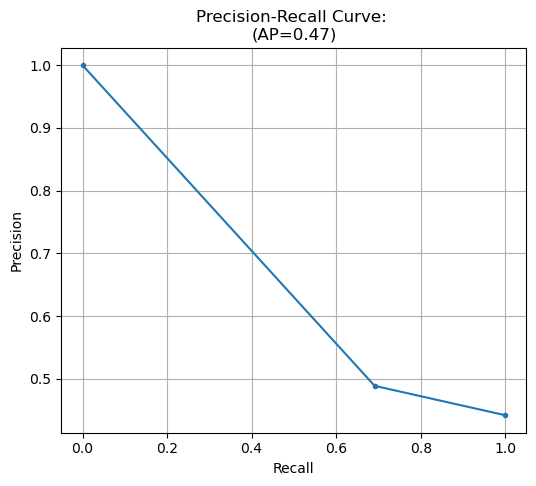

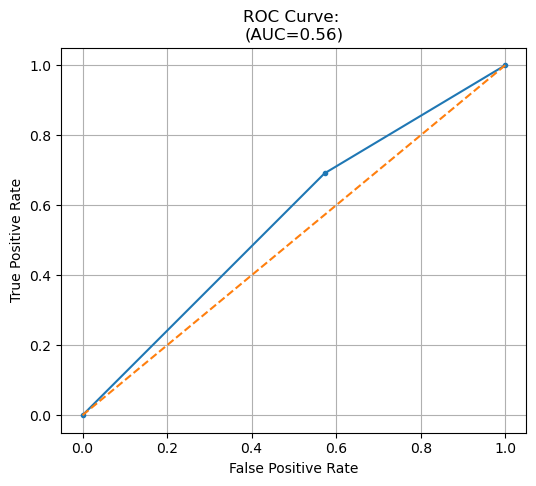


✅ Final Test Accuracy (Threshold = 0.499): 0.5440


In [34]:
#성과 분석 시각화
threshold = 0.499
y_scores = (y_pred_proba >= threshold).astype(int)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_scores)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve 시각화
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve: \n(AP={average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f'ROC Curve: \n(AUC={roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# 5. 최종 Accuracy 출력
final_accuracy = accuracy_score(y_test, y_scores)
print(f"\n✅ Final Test Accuracy (Threshold = {threshold}): {final_accuracy:.4f}")

In [ ]:
start_date_actual = '2021-01-01'
end_date_actual = '2024-12-31'

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual)
df_actual = df_actual.reset_index()

df_actual = df_actual.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df_actual = get_alpha(df_actual)
features = X.columns.tolist()
df_actual = df_actual[features]

# 5. 전체 파이프라인 함수
def select_features(df):
    df = fill_missing(df)
    df = normalize(df)
    return df

# 파이프라인 적용
df_selected_actual = select_features(df_actual)

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual).reset_index()
df_selected_actual['target'] = df_actual['UpDown'].shift(-1)
df_selected_actual['target'] = df_selected_actual['target'].replace(3, 2)
df_selected_actual['target'] = df_selected_actual['target'].replace(1, 0)
df_selected_actual['target'] = df_selected_actual['target'].replace(2, 1)

df_selected_actual = df_selected_actual.dropna()

X_actual = df_selected_actual.drop(columns=['target'])
y_actual = df_selected_actual['target']

# 초기 데이터 (2020년 데이터 등)로 학습 시작
train_X = X.copy()
train_y = y.copy()

predictions = []

threshold = 0.499

for i in range(len(y_actual)):  # prediction_dates = 2021-01-01 ~ 2021-03-31
    
    # 모델 새로 선언
    model = LogisticRegression(
        penalty='l2',
        C=0.01,
        solver='lbfgs',
        class_weight='balanced',
        max_iter=500,
        random_state=42
    )
    model.fit(train_X, train_y)
    
    # 해당 날짜 데이터로 예측
    X_today = X_actual.iloc[i].values.reshape(1, -1)  # 1행짜리로 reshape
    
    y_proba_today = model.predict_proba(X_today)[:, 1]
    y_pred_today = (y_proba_today >= threshold).astype(int)[0]
    predictions.append(y_pred_today)
    
    # 오늘 데이터 학습에 추가
    train_X = pd.concat([train_X, X_actual.iloc[[i]]])
    train_y = pd.concat([train_y, pd.Series([y_actual.iloc[i]], index=[y_actual.index[i]])])


c:\Users\minju\OneDrive\바탕 화면\다트비\캐금스\alpha_code_1.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner[self.returns < 0] = stddev(self.returns, 20)
c:\Users\minju\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\minju\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\minju\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\minju\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid featur

In [77]:
print("🔍 Classification Report:\n", classification_report(y_actual.iloc[:len(predictions)], predictions))

🔍 Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.49      0.50       499
         1.0       0.48      0.49      0.49       483

    accuracy                           0.49       982
   macro avg       0.49      0.49      0.49       982
weighted avg       0.49      0.49      0.49       982

